In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
os.listdir()

['.config', 'drive', 'iot_model.keras', 'iot_scaler.pkl', 'sample_data']

In [11]:
import os
# Suppress TensorFlow AVX/oneDNN warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Set seeds for reproducibility (Important for your research paper!)
np.random.seed(42)
tf.random.set_seed(42)

# ==========================================
# 2. DATA LOADING & PREPROCESSING
# ==========================================

# Load Data
# NOTE: Replace generate_dummy_data() with pd.read_csv('your_file.csv') for real data
df = pd.read_csv('/content/drive/MyDrive/IotAnomalyData/logs.csv')

# Parse timestamp with specific user format
# Format matches "2026-01-0504:44:02"
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d%H:%M:%S', errors='coerce')
df = df.dropna(subset=['timestamp']) # Drop rows where timestamp failed to parse
df = df.set_index('timestamp')

print("Dataset Head:")
print(df.head())

# Define Features (Must match your CSV columns exactly)
features = ['temperature', 'humidity', 'pressure', 'soil moisture']

# Check if 'label' column exists (Ground Truth)
HAS_LABELS = 'label' in df.columns
if not HAS_LABELS:
    print("\n[INFO] No 'label' column found. Running in UNSUPERVISED mode (no F1 score calculation).")
else:
    print("\n[INFO] 'label' column found. Running in VERIFICATION mode (calculating F1/Accuracy).")

# Split into Train and Test
train_size = int(len(df) * 0.70)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Select only feature columns for scaling/training
train_data = train[features]
test_data = test[features]

# Normalize
scaler = MinMaxScaler()
scaler = scaler.fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

def create_sequences(data, time_steps=10):
    output = []
    for i in range(len(data) - time_steps + 1):
        output.append(data[i : (i + time_steps)])
    return np.stack(output)

TIME_STEPS = 30

X_train = create_sequences(train_scaled, TIME_STEPS)
X_test = create_sequences(test_scaled, TIME_STEPS)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Dataset Head:
                     temperature  humidity  pressure  soil moisture
timestamp                                                          
2026-01-05 04:44:02        29.78     76.10   1005.52          52.97
2026-01-05 04:44:03        29.79     74.80   1005.54          52.99
2026-01-05 04:44:04        29.78     74.68   1005.50          52.97
2026-01-05 04:44:05        29.78     74.80   1005.54          52.94
2026-01-05 04:44:06        29.78     74.81   1005.50          52.97

[INFO] No 'label' column found. Running in UNSUPERVISED mode (no F1 score calculation).
X_train shape: (89793, 30, 4)
X_test shape: (38467, 30, 4)


In [12]:
# ==========================================
# 3. BUILD LSTM AUTOENCODER MODEL
# ==========================================

model = Sequential([
    # Encoder
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    BatchNormalization(),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False), # Bottleneck layer

    # Bridge
    RepeatVector(X_train.shape[1]),

    # Decoder
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Early stopping to prevent overfitting on the large dataset
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nStarting Training on Deep Architecture...")
history = model.fit(
    X_train, X_train,
    epochs=50, # Can afford more epochs with EarlyStopping
    batch_size=64, # Slightly larger batch size for stability with more rows
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 4)          │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,172 (1.00 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 384 (1.50 KB)


Starting Training on Deep Architecture...
Epoch 1/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 262s 205ms/step - loss: 0.0174 - val_loss: 6.0324e-04
Epoch 2/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 250s 210ms/step - loss: 0.0082 - val_loss: 0.0176
Epoch 3/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 252s 211ms/step - loss: 0.0022 - val_loss: 0.0056
Epoch 4/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 252s 203ms/step - loss: 0.0011 - val_loss: 5.4646e-04
Epoch 5/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 243s 204ms/step - loss: 5.9536e-04 - val_loss: 6.2603e-04
Epoch 6/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 241s 202ms/step - loss: 4.7642e-04 - val_loss: 7.4078e-04
Epoch 7/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 242s 203ms/step - loss: 2.9629e-04 - val_loss: 3.9392e-04
Epoch 8/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 262s 203ms/step - loss: 2.3784e-04 - val_loss: 8.8439e-04
Epoch 9/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 270s 210ms/step - loss: 2.2367e-04 - val_loss: 7.3154e-04
Epoch 10/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 255s 204ms/step - loss: 2.0740e-04 - v

In [13]:
# ==========================================
# 4. TRAIN MODEL
# ==========================================

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=(1, 2))

X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

threshold = np.mean(train_mae_loss) + 3 * np.std(train_mae_loss)
pred_anomalies = (test_mae_loss > threshold).astype(int)

2807/2807 ━━━━━━━━━━━━━━━━━━━━ 114s 40ms/step
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step



[INFO] Unsupervised mode: Use the reconstruction error plot for validation.


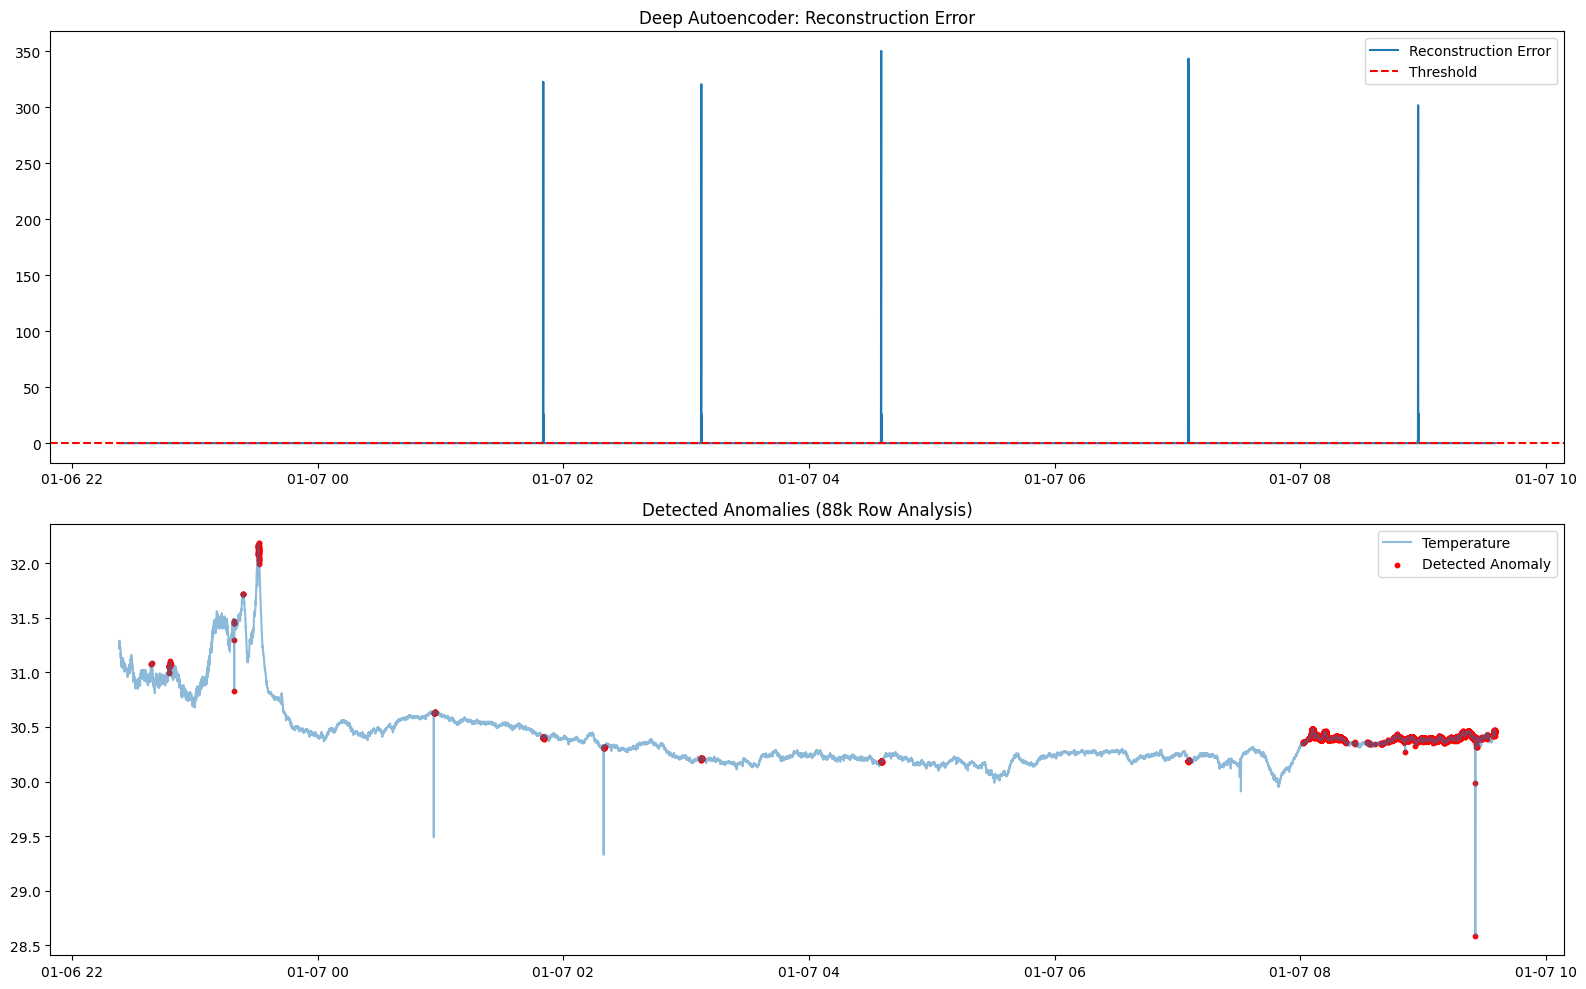

In [14]:
if HAS_LABELS:
    y_test_ground_truth = test['label'].values[TIME_STEPS-1:]
    print("\n" + "="*40)
    print("MODEL EVALUATION METRICS")
    print(classification_report(y_test_ground_truth, pred_anomalies))
else:
    print("\n[INFO] Unsupervised mode: Use the reconstruction error plot for validation.")

# ==========================================
# 6. VISUALIZATION
# ==========================================
test_score_df = pd.DataFrame(index=test[TIME_STEPS-1:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = pred_anomalies
test_score_df['temperature'] = test[TIME_STEPS-1:]['temperature']

plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(test_score_df.index, test_score_df['loss'], label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Deep Autoencoder: Reconstruction Error')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_score_df.index, test_score_df['temperature'], label='Temperature', alpha=0.5)
anoms = test_score_df[test_score_df['anomaly'] == 1]
plt.scatter(anoms.index, anoms['temperature'], color='red', label='Detected Anomaly', s=10)
plt.title('Detected Anomalies (88k Row Analysis)')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# ==========================================
# 7. DEPLOYMENT (Save to Disk)
# ==========================================
print("\n" + "="*40)
print("DEPLOYMENT EXPORT")
print("="*40)

# Save the Scaler (CRITICAL for preprocessing new real-time data)
scaler_filename = "iot_scaler.pkl"
joblib.dump(scaler, scaler_filename)
print(f"1. Scaler saved to: {scaler_filename}")

# Save the Model (Keras format is safer for Neural Networks than joblib)
model_filename = "iot_model.keras"
model.save(model_filename)
print(f"2. Model saved to: {model_filename}")


DEPLOYMENT EXPORT
1. Scaler saved to: iot_scaler.pkl
2. Model saved to: iot_model.keras
